# Fallbacks with Branching Pipelines

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [1]:
from haystack import Pipeline
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.websearch.serper_dev import SerperDevWebSearch #conditional router


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### We reuse the ElasticDocumentStore

In [ ]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

from haystack.utils import Secret


document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")

In [4]:
document_store.filter_documents()[1]

Document(id=8208d073fc88b3b2f1f82bbc20e6177626471e19fe31e86c8213964b55e79781, content: ' He was the second son of Arthur Reuel Tolkien, a bank manager, and Mabel Suffield.', meta: {'file_path': 'data/tolkien.txt', 'source_id': 'b4dd8cf407a5c9917b7a435288375829a0f32fa11e2064c64fc88dedbbe906b5', 'page_number': 1, 'split_id': 1, 'split_idx_start': 195}, score: 1.0, embedding: vector of size 384)

### Create RAG Pipeline

In [5]:
rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

In [6]:
query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever =ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt = PromptBuilder(template=rag_prompt_template)
generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))


In [7]:
rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever",retriever )
rag.add_component("prompt_builder", prompt)
rag.add_component("llm", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: ElasticsearchEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

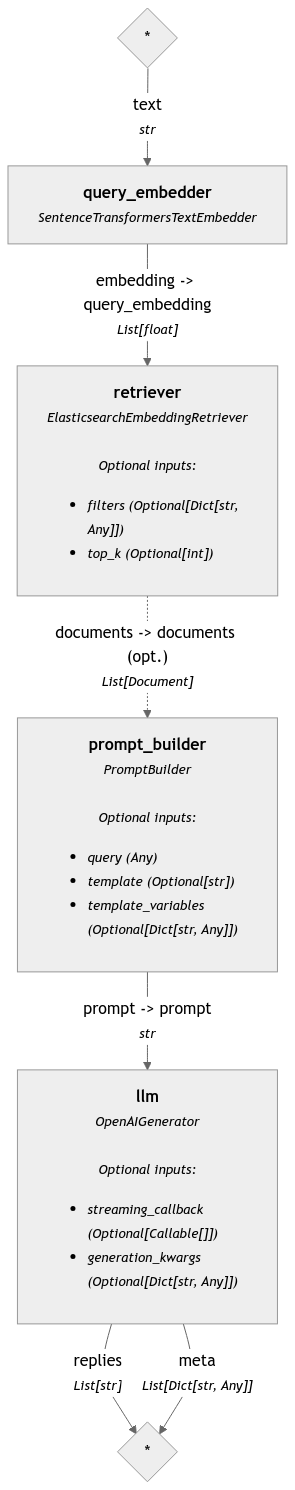

In [8]:
rag.show()

In [9]:
query = "Who is J. R.R. Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
        include_outputs_from={"retriever"}
)



Batches: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


In [10]:
rich.print(result["llm"]["replies"][0])

John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is a revered figure in 
literature, particularly known for his contributions to the genre of high fantasy.

In [11]:
query = "Who is George Martin?"
result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
)

Batches: 100%|██████████| 1/1 [00:00<00:00, 49.55it/s]


In [12]:
rich.print(result["llm"]["replies"][0])

no_answer

### Create Conditional Routes


Now that you got the model to respond with an answer or `no_answer`, you can create pipeline branches that are activated according to this response using the [`ConditionalRouter`](https://docs.haystack.deepset.ai/docs/conditionalrouter?utm_campaign=developer-relations&utm_source=dlai) component for this.

ConditionalRouter routes your data through different paths down the pipeline by evaluating the conditions that you specified.

The following are two different routes that the pipeline can take: if in the reply of the generator, there are the words 'no_answer', then go to the route 'go_to_websearch'. Instead, if 'no_answer' is not in the answer, then give the response and stop the pipeline.

In [13]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch", 
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

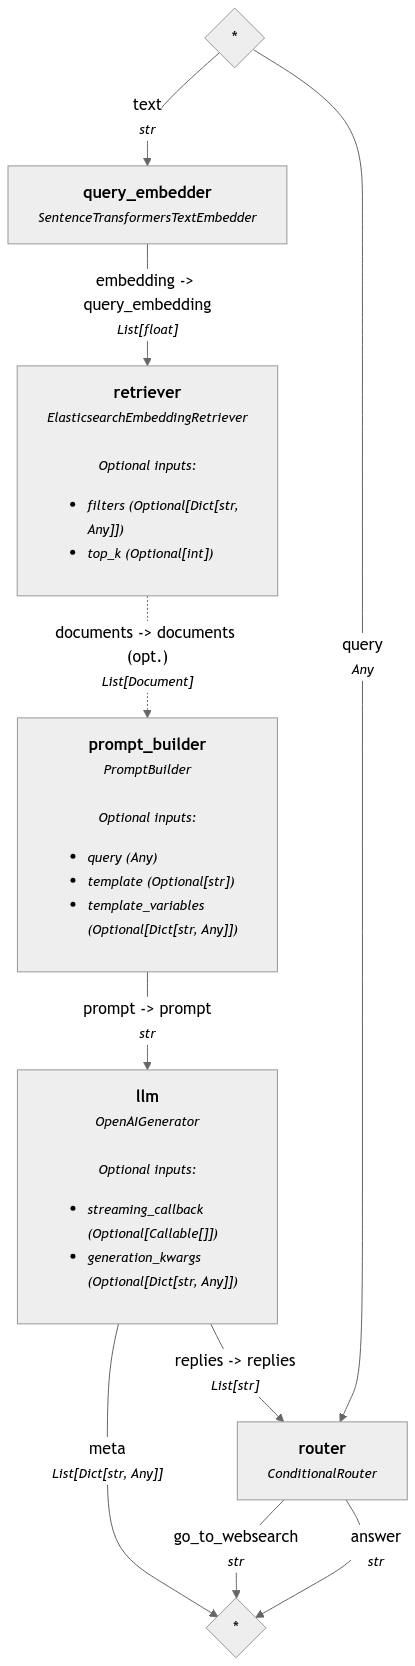

In [14]:
rag.add_component("router", ConditionalRouter(routes=routes))
rag.connect("llm.replies", "router.replies")

rag.show()

In [15]:
query = "Who is Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query},
    "router": {"query": query}} # We pass the query to the router because we need it in case we go to websearch
)

result

Batches: 100%|██████████| 1/1 [00:00<00:00, 42.16it/s]


{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 47,
     'prompt_tokens': 139,
     'total_tokens': 186,
     'completion_tokens_details': CompletionTokensDetails(audio_tokens=None, reasoning_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=None, cached_tokens=0)}}]},
 'router': {'answer': 'John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, stands as one of the most revered figures in the realm of literature, particularly in the genre of high fantasy.'}}

In [16]:
query = "Who is George Martin?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query},
    "router": {"query": query}} # We pass the query to the router because we need it in case we go to websearch
)

result

Batches: 100%|██████████| 1/1 [00:00<00:00, 52.78it/s]


{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 2,
     'prompt_tokens': 106,
     'total_tokens': 108,
     'completion_tokens_details': CompletionTokensDetails(audio_tokens=None, reasoning_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=None, cached_tokens=0)}}]},
 'router': {'go_to_websearch': 'Who is George Martin?'}}

### Create Websearch Branch


In [17]:
prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
You can also reference the URLs that the answer was generated from

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

### Build a Pipeline with Conditional Routes

To perform the web search, we use the components SerperDevWebSearch. When you give SerperDevWebSearch a query, it returns a list of the URLs most relevant to your search. It uses page snippets (pieces of text displayed under the page title in search results) to find the answers, not the whole pages.

In [18]:
WS_API_TOKEN = os.getenv("WS_API_TOKEN")

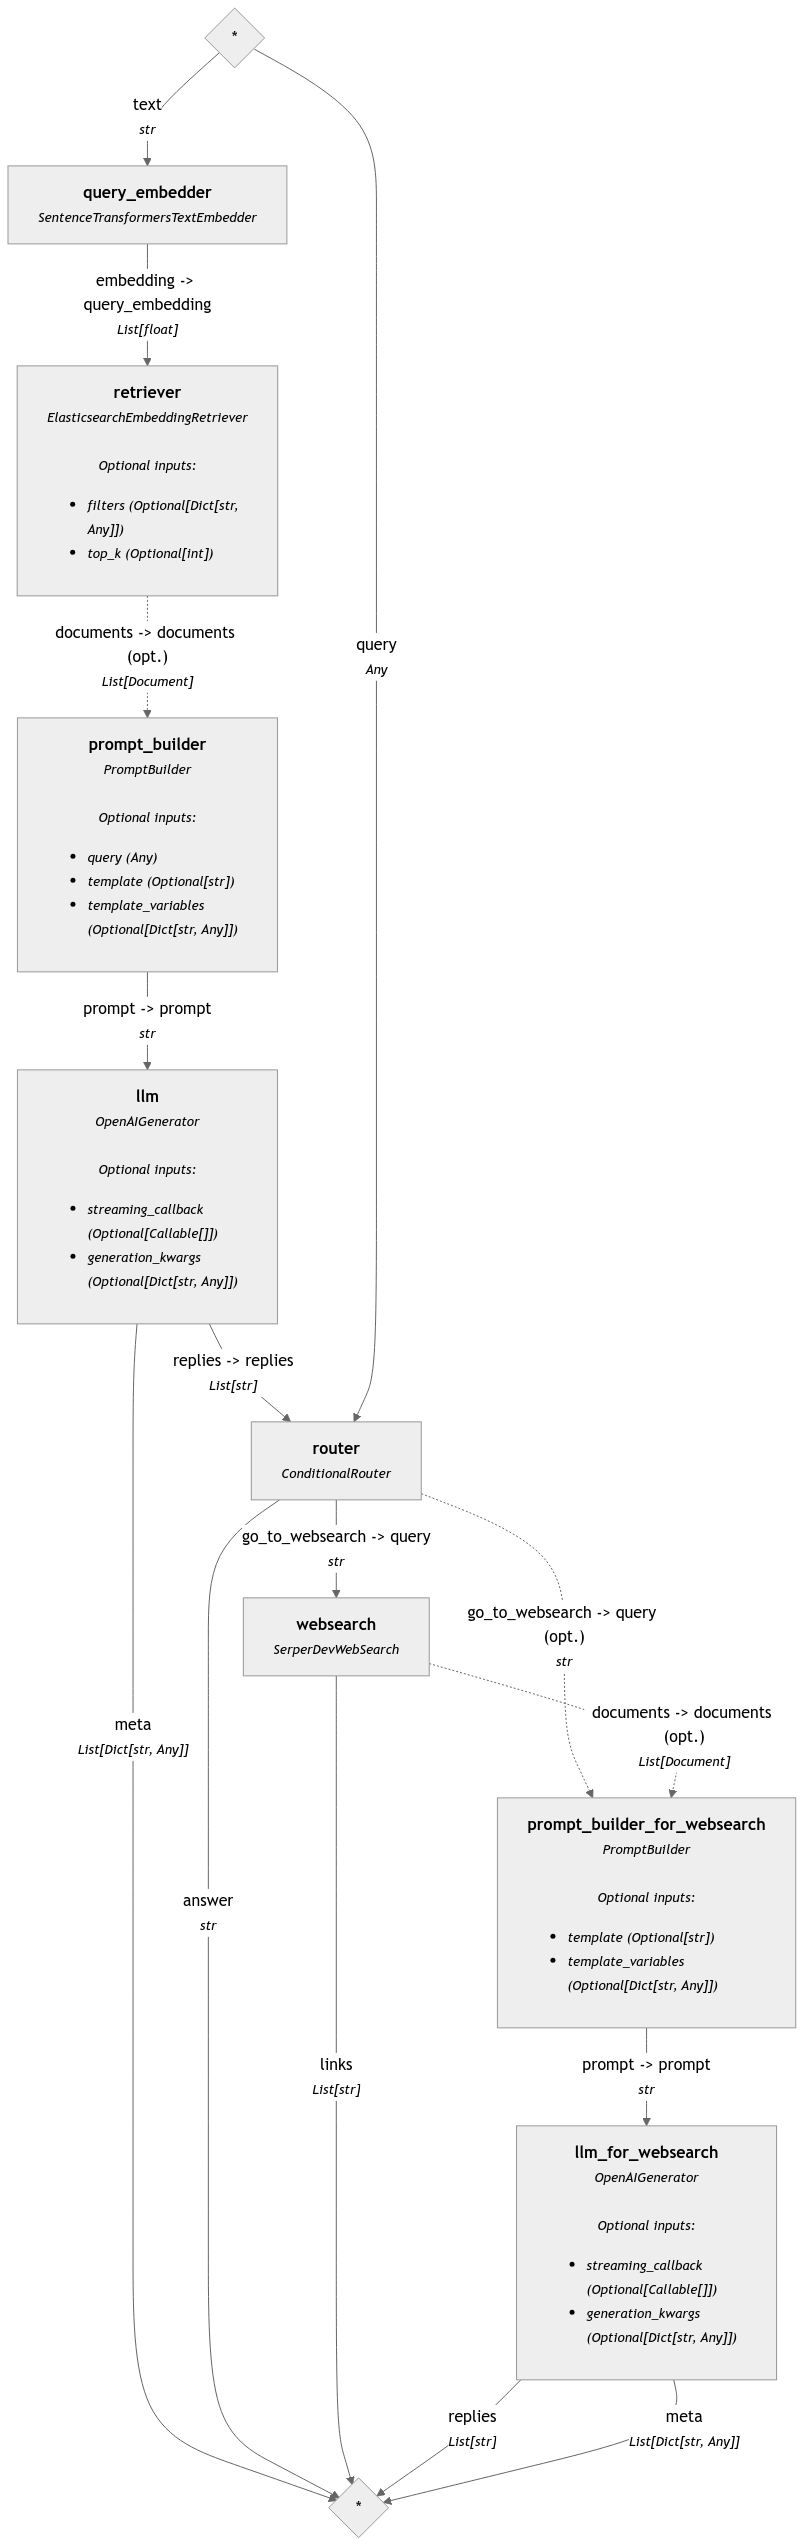

In [19]:
rag_or_websearch = Pipeline()
rag_or_websearch.add_component("query_embedder", SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2"))
rag_or_websearch.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3))
rag_or_websearch.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag_or_websearch.add_component("llm", OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN)))
rag_or_websearch.add_component("router", ConditionalRouter(routes))
rag_or_websearch.add_component("websearch", SerperDevWebSearch(api_key=Secret.from_token(WS_API_TOKEN))) 
rag_or_websearch.add_component("prompt_builder_for_websearch", PromptBuilder(template=prompt_for_websearch))
rag_or_websearch.add_component("llm_for_websearch",  OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN)))

rag_or_websearch.connect("query_embedder.embedding", "retriever.query_embedding")
rag_or_websearch.connect("retriever.documents", "prompt_builder.documents")
rag_or_websearch.connect("prompt_builder", "llm")
rag_or_websearch.connect("llm.replies", "router.replies")
rag_or_websearch.connect("router.go_to_websearch", "websearch.query")
rag_or_websearch.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
rag_or_websearch.connect("websearch.documents", "prompt_builder_for_websearch.documents")
rag_or_websearch.connect("prompt_builder_for_websearch", "llm_for_websearch")

rag_or_websearch.show()

In [30]:
query= "Who is George R.R. Martin?"

result = rag_or_websearch.run({"query_embedder": {"text": query}, 
                      "prompt_builder":{"query": query},
                      "router": {"query": query}},
                      include_outputs_from=["llm", "router", "websearch"])

Batches: 100%|██████████| 1/1 [00:00<00:00, 25.74it/s]


In [31]:
result

{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 2,
     'prompt_tokens': 129,
     'total_tokens': 131,
     'completion_tokens_details': CompletionTokensDetails(audio_tokens=None, reasoning_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=None, cached_tokens=0)}}],
  'replies': ['no_answer']},
 'websearch': {'links': ['https://en.wikipedia.org/wiki/George_R._R._Martin',
   'https://georgerrmartin.com/about-george/life-and-times/',
   'https://www.britannica.com/biography/George-R-R-Martin',
   'https://www.facebook.com/georgerrmartinofficial/',
   'https://www.instagram.com/grrm_nm/?hl=en',
   'https://georgerrmartin.com/',
   'https://www.northwestern.edu/about/our-people/george-r.r.-martin.html',
   'https://www.ecegurler.com/post/george-r-r-martin-s-writer-s-block',
   'https://twitter.com/grrmspeaking?lang=en'],
  'documents': [Document(id=41ed031ed0ed3de10665882c43fafad9

In [32]:
rich.print(result['llm']['replies'][0])

no_answer

In [33]:
rich.print(result['llm_for_websearch']['replies'][0])

George R.R. Martin is an American author, television writer, and producer, best known for his epic fantasy series 
"A Song of Ice and Fire," which served as the basis for the highly acclaimed television adaptation "Game of 
Thrones." He was born on September 20, 1948, in Bayonne, New Jersey. Martin has been a professional writer for many
decades and gained mainstream acclaim with his fantasy works (source: 
[Wikipedia](https://en.wikipedia.org/wiki/George_R._R._Martin), [Facebook 
page](https://www.facebook.com/georgerrmartin), [Not a Blog](http://georgerrmartin.com/notablog)).